In [ ]:
!pip install ydata-profiling > /dev/null 2>&1
import os
import warnings
from datetime import date
import math
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import drive
import holidays
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/BIS Project')
print("Current Directory: ", os.getcwd() )
print(os.listdir( '.' ))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory:  /content/drive/My Drive/BIS Project
['Ecom_climate.csv', 'ONTARIO-2024.xlsx', 'ONTARIO-2023.xlsx', 'investments_data.csv', 'ConsumerElectronicsv1.csv', 'Media data and other information.xlsx', 'HomeAudio.csv', 'CameraAccessory.csv', 'GamingAccessory.csv', 'data.csv', 'homeaudio_profile_report.html', 'HomeAudio_reduced_profile_report.html', 'CameraAccessory_reduced_profile_report.html', 'GamingAccessory_reduced_profile_report.html']


In [ ]:
#Import the order data set
data=[]
def readDataset(product):
  df=pd.read_csv(product, encoding='latin-1')
  name=product.split('.')[0]
  data.append((name,df))

readDataset('HomeAudio.csv')
readDataset('CameraAccessory.csv')
readDataset('GamingAccessory.csv')

def printDataset(data):
  for name,df in data:
    print(f"The {name} dataset was loaded successfully", end='\n\n')
    print(df.head())

printDataset(data)

The HomeAudio dataset was loaded successfully

   Unnamed: 0  order_date  Year  Month                 order_id  \
0        2460  2023-10-03  2023     10 1,407,395,732,747,800.00   
1        2461  2023-10-16  2023     10 2,418,213,882,235,600.00   
2        2462  2023-10-16  2023     10 2,418,675,653,264,600.00   
3        2463  2023-10-16  2023     10 1,418,727,172,944,200.00   
4        2464  2023-10-20  2023     10 2,421,983,590,777,500.00   

             order_item_id      gmv  units  deliverybdays  deliverycdays  ...  \
0 1,407,395,732,747,800.00 7,049.00      1              0              0  ...   
1 2,418,213,882,235,600.00 5,489.00      1              0              0  ...   
2 2,418,675,653,264,600.00 6,255.00      1              0              0  ...   
3 1,418,727,172,944,200.00 6,099.00      1              0              0  ...   
4 2,421,983,590,777,500.00 6,850.00      1              0              0  ...   

  inc_PO_MA3  LP_lag_1_per LP_lag_2_per LP_lag_3_per PO_lag_1_p

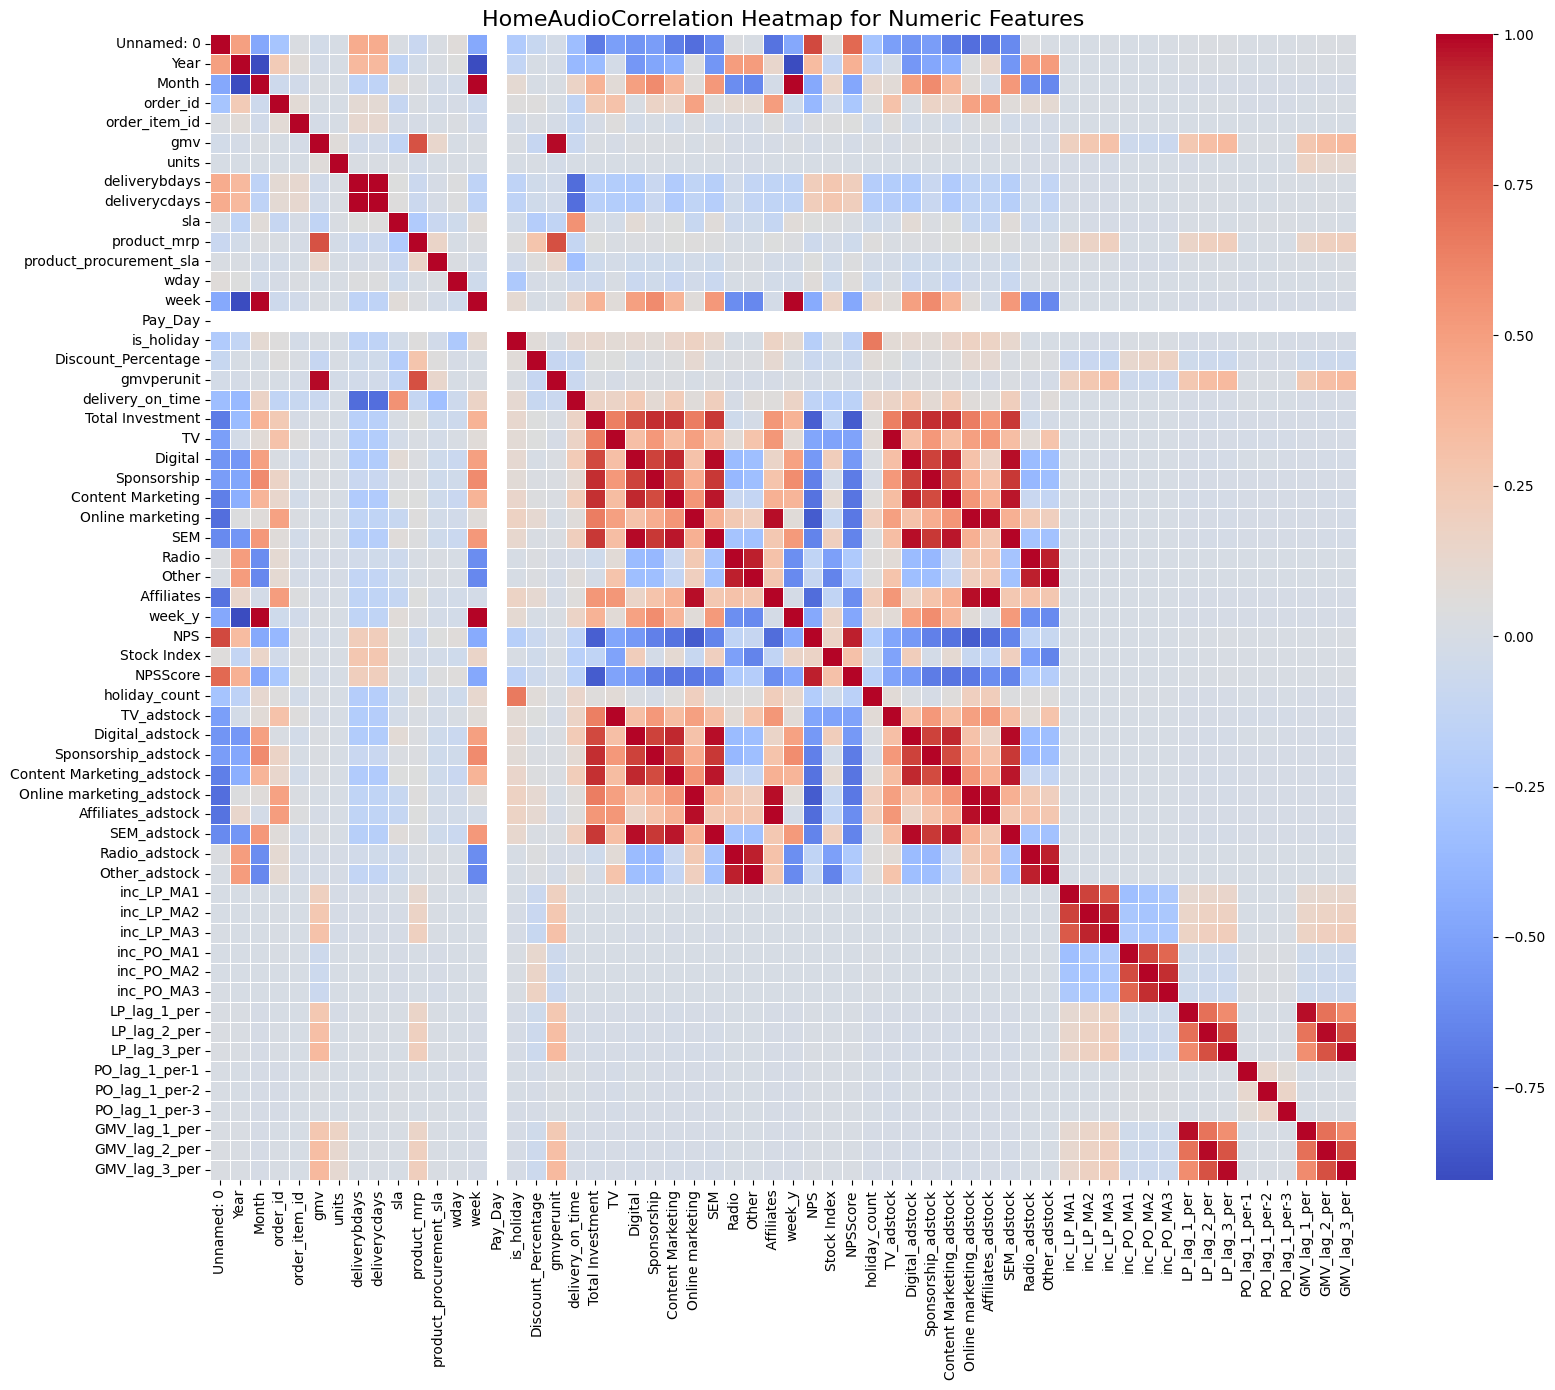

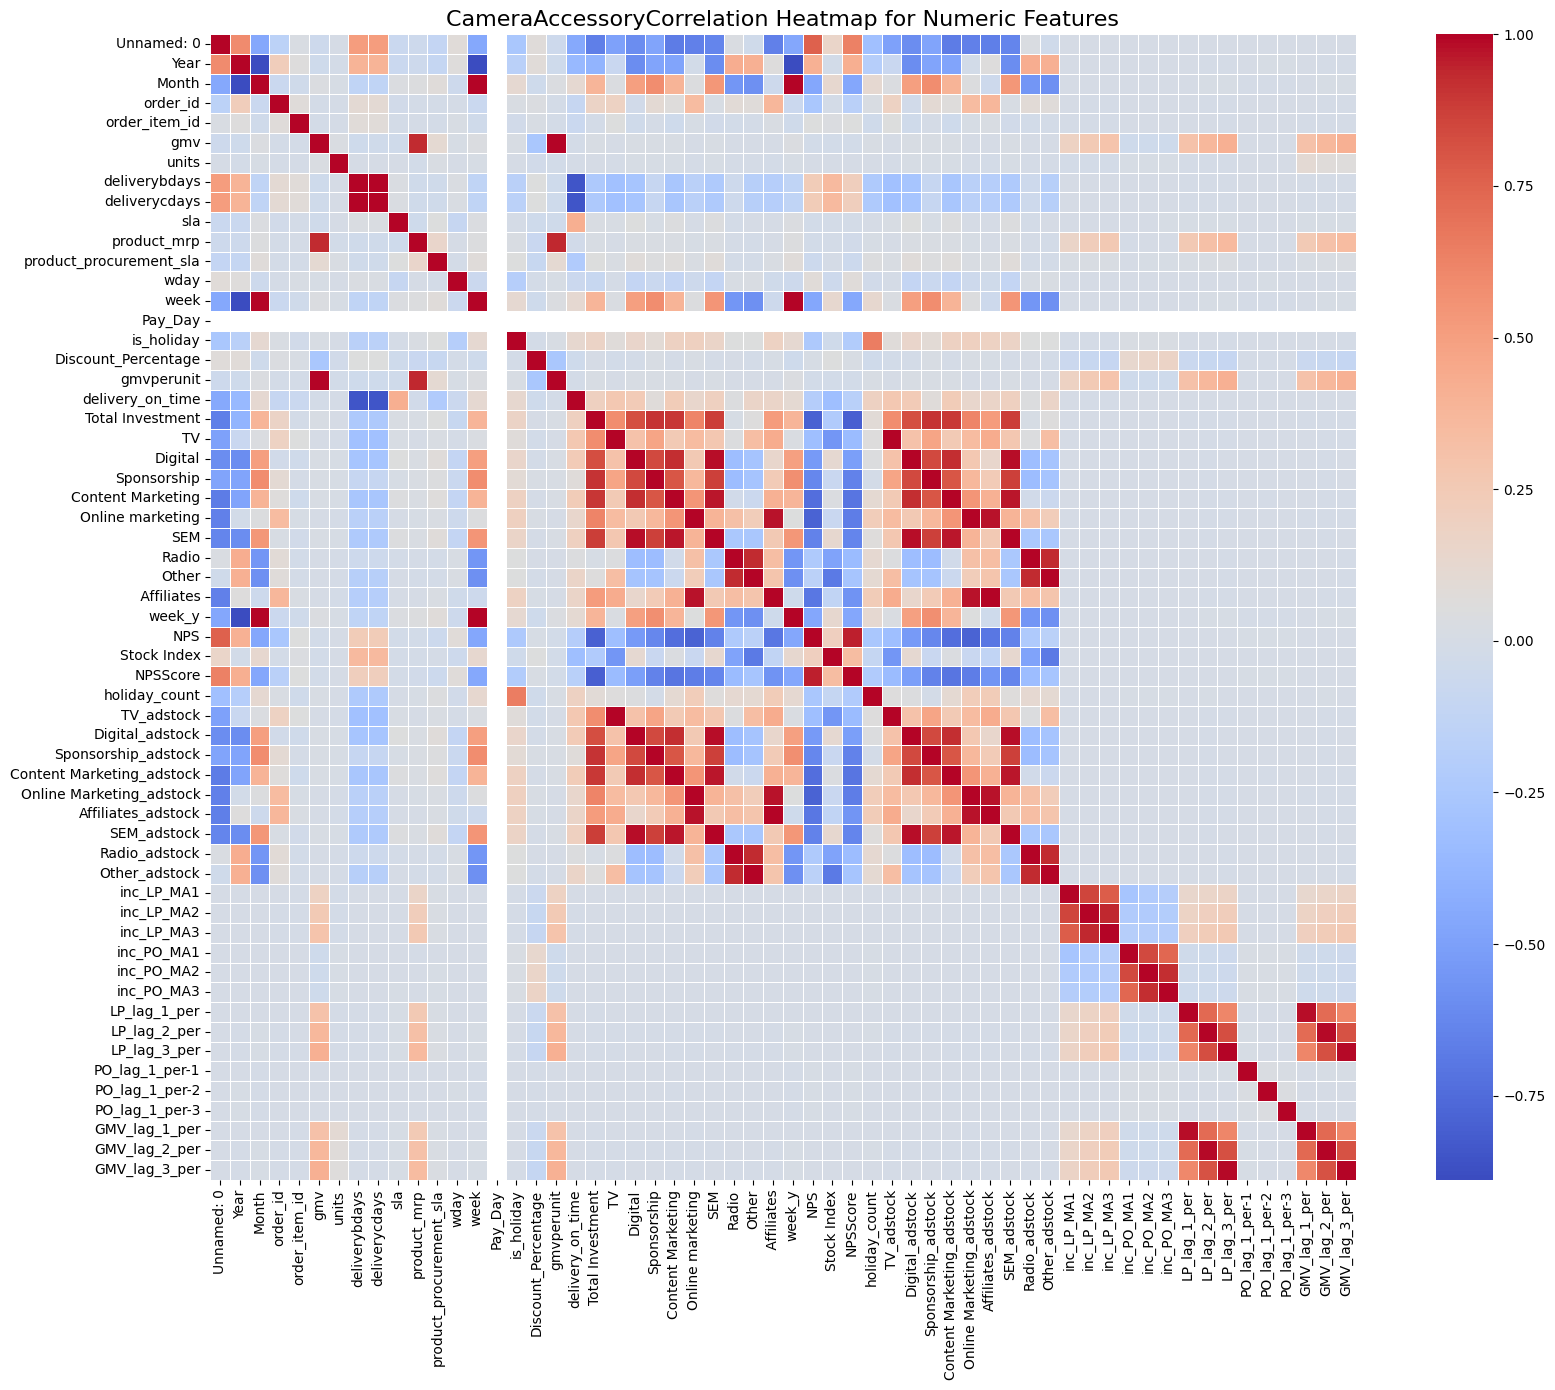

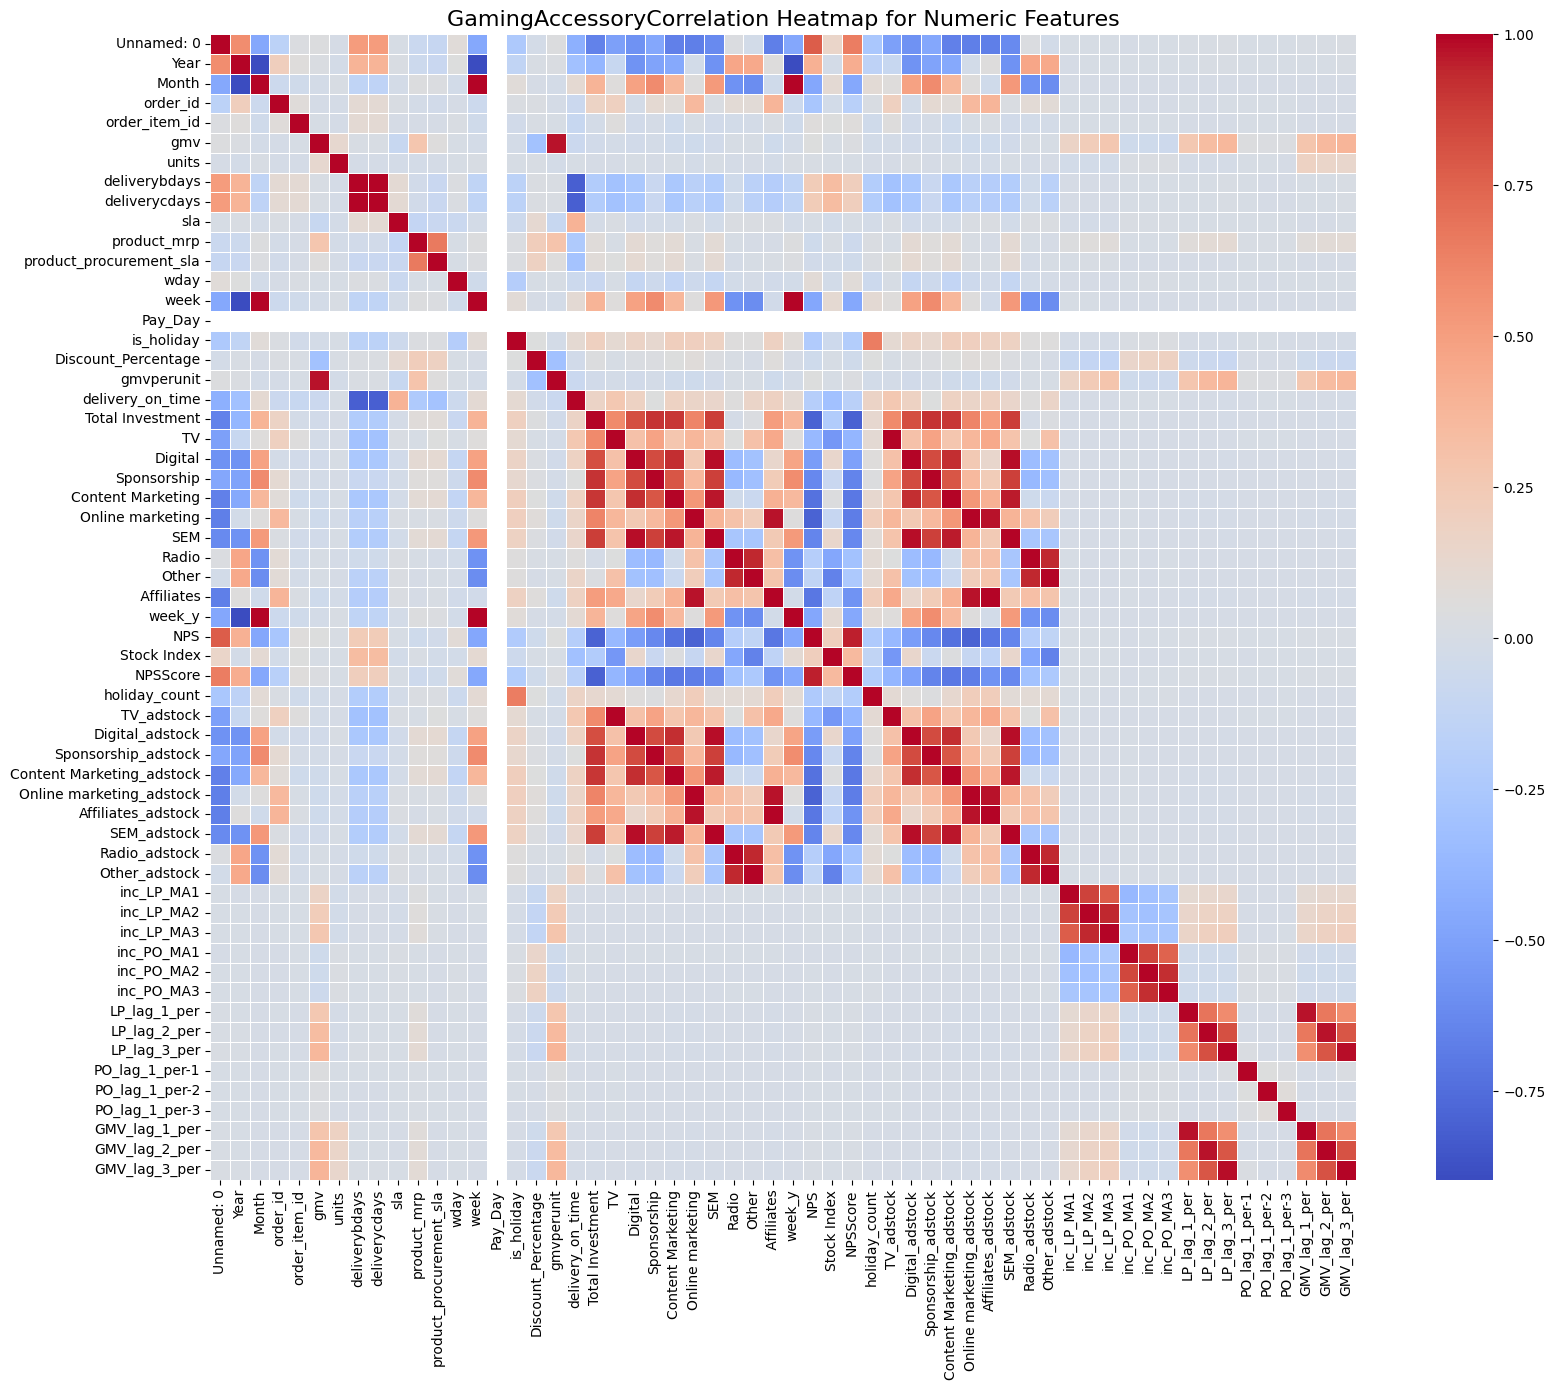

In [ ]:
#Dropping variables with high multi-collinearity
# Compute correlation matrix for numeric columns only

def corrMatrix():
  for name,df in data:
    corr_matrix = df.select_dtypes(include=[np.number]).corr()
    # Plot heatmap
    plt.figure(figsize=(18, 14))
    sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    linewidths=0.5,
    fmt=".2f",
    square=True,
    cbar=True
    )
    plt.title(f"{name}Correlation Heatmap for Numeric Features", fontsize=16)
    plt.tight_layout()

corrMatrix()


In [ ]:
# Compute correlation matrix
data_reduced=[]

for name,df in data:
  corr_matrix = df.select_dtypes(include=[np.number]).corr().abs()
  # Find highly correlated pairs
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
  # Drop them from the dataset
  df_reduced = df.drop(columns=to_drop)
  name=name+"_reduced"
  data_reduced.append((name,df_reduced))

In [ ]:
name1,df1=data_reduced[0]
print(name1, end='\n\n')
df1.head()

HomeAudio_reduced



,Unnamed: 0,order_date,Year,order_id,order_item_id,gmv,units,deliverybdays,s1_fact_order_payment_type,sla,...,holiday_count,ItemType,month_date,inc_LP_MA1,inc_PO_MA1,LP_lag_1_per,LP_lag_2_per,PO_lag_1_per-1,PO_lag_1_per-2,PO_lag_1_per-3
0,2460,2023-10-03,2023,"1,407,395,732,747,800.00","1,407,395,732,747,800.00","7,049.00",1,0,Prepaid,5,...,0.00,Luxury,2023-10-03-10,NaN,NaN,0.28,0.13,-0.78,-0.64,-0.68
1,2461,2023-10-16,2023,"2,418,213,882,235,600.00","2,418,213,882,235,600.00","5,489.00",1,0,Prepaid,2,...,2.00,Luxury,2023-10-16-10,-0.12,0.63,-0.12,-0.10,0.62,0.44,2.10
2,2462,2023-10-16,2023,"2,418,675,653,264,600.00","2,418,675,653,264,600.00","6,255.00",1,0,Prepaid,9,...,2.00,Luxury,2023-10-16-10,0.07,-0.24,0.03,-0.09,-0.11,0.92,0.92
3,2463,2023-10-16,2023,"1,418,727,172,944,200.00","1,418,727,172,944,200.00","6,099.00",1,0,Prepaid,3,...,2.00,Luxury,2023-10-16-10,-0.01,0.06,-0.11,-0.11,1.16,1.16,0.00
4,2464,2023-10-20,2023,"2,421,983,590,777,500.00","2,421,983,590,777,500.00","6,850.00",1,0,COD,9,...,2.00,Luxury,2023-10-20-10,0.06,-0.37,0.00,0.12,0.00,-0.54,-0.54


In [ ]:
name2,df2=data_reduced[1]
print(name2, end='\n\n')
df2.head()

CameraAccessory_reduced



,Unnamed: 0,order_date,Year,order_id,order_item_id,gmv,units,deliverybdays,s1_fact_order_payment_type,sla,...,holiday_count,ItemType,month_date,inc_LP_MA1,inc_PO_MA1,LP_lag_1_per,LP_lag_2_per,PO_lag_1_per-1,PO_lag_1_per-2,PO_lag_1_per-3
0,0,2023-10-17,2023,"3,419,300,926,147,000.00","3,419,300,926,147,000.00","6,400.00",1,0,COD,5,...,2.00,Luxury,2023-10-17-10,NaN,NaN,-0.07,2.22,1.72,1.12,-0.44
1,1,2023-10-19,2023,"1,420,830,839,915,200.00","1,420,830,839,915,200.00","6,900.00",1,0,COD,7,...,2.00,Luxury,2023-10-19-10,0.04,-0.46,2.47,3.08,-0.22,-0.79,-0.82
2,2,2023-10-20,2023,"2,421,912,925,714,800.00","2,421,912,925,714,800.00","1,990.00",1,0,COD,10,...,2.00,MassMarket,2023-10-20-10,-0.55,0.13,0.18,0.23,-0.73,-0.77,-0.71
3,3,2023-10-14,2023,"4,416,592,101,738,400.00","4,416,592,101,738,400.00","1,690.00",1,0,Prepaid,4,...,2.00,MassMarket,2023-10-14-10,-0.08,0.58,0.04,-0.49,-0.15,0.09,1.26
4,4,2023-10-17,2023,"4,419,525,153,426,400.00","4,419,525,153,426,400.00","1,618.00",1,0,Prepaid,6,...,2.00,MassMarket,2023-10-17-10,-0.02,0.08,-0.51,-0.56,0.29,1.66,1.66


In [ ]:
name3,df3=data_reduced[2]
print(name3, end='\n\n')
df3.head()

GamingAccessory_reduced



,Unnamed: 0,order_date,Year,order_id,order_item_id,gmv,units,deliverybdays,s1_fact_order_payment_type,sla,...,holiday_count,ItemType,month_date,inc_LP_MA1,inc_PO_MA1,LP_lag_1_per,LP_lag_2_per,PO_lag_1_per-1,PO_lag_1_per-2,PO_lag_1_per-3
0,1555,2023-10-04,2023,"1,408,216,975,064,600.00","1,408,216,975,064,600.00","3,075.00",1,0,COD,9,...,0.00,Luxury,2023-10-04-10,NaN,NaN,0.12,0.06,-0.26,-0.16,-0.34
1,1556,2023-10-14,2023,"1,416,985,339,691,600.00","1,416,985,339,691,600.00","2,750.00",1,0,COD,7,...,2.00,Luxury,2023-10-14-10,-0.06,0.15,-0.05,0.05,0.14,-0.10,0.02
2,1557,2023-10-15,2023,"1,417,669,228,375,400.00","1,417,669,228,375,400.00","2,899.00",1,0,Prepaid,5,...,2.00,Luxury,2023-10-15-10,0.03,-0.06,0.11,0.05,-0.21,-0.10,-0.12
3,1558,2023-10-17,2023,"1,419,414,998,353,400.00","1,419,414,998,353,400.00","2,609.00",1,0,Prepaid,5,...,2.00,Luxury,2023-10-17-10,-0.05,0.12,-0.06,-0.05,0.13,0.11,0.39
4,1559,2023-10-26,2023,"1,427,167,582,532,600.00","1,427,167,582,532,600.00","2,772.00",1,0,Prepaid,5,...,0.00,Luxury,2023-10-26-10,0.03,-0.06,0.01,-0.08,-0.02,0.23,0.33


In [ ]:
def generate_profile_reports():
  for name,df in data_reduced:
    #Generate the profile report
   profile = ProfileReport(df)
    # To display in notebook
   profile.to_notebook_iframe()
    # Optionally save to HTML
   htmlName = f"{name}_profile_report.html"
   profile.to_file(htmlName)
   print(f"Saved: {htmlName}\n")

#generate_profile_reports()

In [ ]:
data_mod=[]
columns_to_drop = ['Unnamed: 0', 'Year', 'Month', 'week_y', 'order_id', 'order_item_id', 'order_date', 'order_month', 'month_date']

def colclean(col):
    for name, df in data_reduced:
        # Find which columns are present
        cols_to_drop = [c for c in col if c in df.columns]
        dm = df.drop(columns=cols_to_drop)
        # Replace inf/-inf with NaN and drop rows with NaN
        dm.replace([np.inf, -np.inf], np.nan, inplace=True)
        dm.dropna(inplace=True)
        data_mod.append((name, dm))

colclean(columns_to_drop)

In [ ]:
name1,df1=data_mod[0]
print(name1, end='\n\n')
df1.head()

HomeAudio_reduced



,gmv,units,deliverybdays,s1_fact_order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_procurement_sla,wday,...,Stock Index,holiday_count,ItemType,inc_LP_MA1,inc_PO_MA1,LP_lag_1_per,LP_lag_2_per,PO_lag_1_per-1,PO_lag_1_per-2,PO_lag_1_per-3
1,"5,489.00",1,0,Prepaid,2,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,-0.12,0.63,-0.12,-0.10,0.62,0.44,2.10
2,"6,255.00",1,0,Prepaid,9,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,0.07,-0.24,0.03,-0.09,-0.11,0.92,0.92
3,"6,099.00",1,0,Prepaid,3,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,-0.01,0.06,-0.11,-0.11,1.16,1.16,0.00
4,"6,850.00",1,0,COD,9,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,4,...,1210,2.00,Luxury,0.06,-0.37,0.00,0.12,0.00,-0.54,-0.54
5,"6,850.00",1,0,Prepaid,4,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,0.00,Luxury,0.00,0.00,0.12,0.12,-0.54,-0.54,0.00


In [ ]:
name2,df2=data_mod[1]
print(name2, end='\n\n')
df1.head()

CameraAccessory_reduced



,gmv,units,deliverybdays,s1_fact_order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_procurement_sla,wday,...,Stock Index,holiday_count,ItemType,inc_LP_MA1,inc_PO_MA1,LP_lag_1_per,LP_lag_2_per,PO_lag_1_per-1,PO_lag_1_per-2,PO_lag_1_per-3
1,"5,489.00",1,0,Prepaid,2,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,-0.12,0.63,-0.12,-0.10,0.62,0.44,2.10
2,"6,255.00",1,0,Prepaid,9,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,0.07,-0.24,0.03,-0.09,-0.11,0.92,0.92
3,"6,099.00",1,0,Prepaid,3,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,-0.01,0.06,-0.11,-0.11,1.16,1.16,0.00
4,"6,850.00",1,0,COD,9,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,4,...,1210,2.00,Luxury,0.06,-0.37,0.00,0.12,0.00,-0.54,-0.54
5,"6,850.00",1,0,Prepaid,4,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,0.00,Luxury,0.00,0.00,0.12,0.12,-0.54,-0.54,0.00


In [ ]:
name3,df3=data_mod[0]
print(name3, end='\n\n')
df1.head()

HomeAudio_reduced



,gmv,units,deliverybdays,s1_fact_order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_procurement_sla,wday,...,Stock Index,holiday_count,ItemType,inc_LP_MA1,inc_PO_MA1,LP_lag_1_per,LP_lag_2_per,PO_lag_1_per-1,PO_lag_1_per-2,PO_lag_1_per-3
1,"5,489.00",1,0,Prepaid,2,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,-0.12,0.63,-0.12,-0.10,0.62,0.44,2.10
2,"6,255.00",1,0,Prepaid,9,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,0.07,-0.24,0.03,-0.09,-0.11,0.92,0.92
3,"6,099.00",1,0,Prepaid,3,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,2.00,Luxury,-0.01,0.06,-0.11,-0.11,1.16,1.16,0.00
4,"6,850.00",1,0,COD,9,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,4,...,1210,2.00,Luxury,0.06,-0.37,0.00,0.12,0.00,-0.54,-0.54
5,"6,850.00",1,0,Prepaid,4,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,5,0,...,1210,0.00,Luxury,0.00,0.00,0.12,0.12,-0.54,-0.54,0.00


In [ ]:
data_final=[]

def manipltn():
    for name, df in data_mod:
        num_cols = df.select_dtypes(include=['float64', 'int64']).columns
        cat_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
        preprocessor = ColumnTransformer([
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)])
        X_processed = preprocessor.fit_transform(df)
        # Get column names
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
        all_features = list(num_cols) + list(cat_features)

        # Create processed DataFrame
        df_processed = pd.DataFrame(X_processed, columns=all_features, index=df.index)
        name = name.replace("_reduced", "_final")

        data_final.append((name, df_processed))

manipltn()


In [ ]:
name1,df1=data_final[0]
print(name1, end='\n\n')
df1.head()

HomeAudio_final



,gmv,units,deliverybdays,sla,product_procurement_sla,wday,Pay_Day,is_holiday,Discount_Percentage,delivery_on_time,...,product_analytic_vertical_FMRadio,product_analytic_vertical_HiFiSystem,product_analytic_vertical_HomeAudioSpeaker,product_analytic_vertical_KaraokePlayer,product_analytic_vertical_SlingBox,product_analytic_vertical_SoundMixer,product_analytic_vertical_VoiceRecorder,delivery_status_Early,delivery_status_On time,ItemType_MassMarket
1,1.67,-0.06,-0.39,-1.25,1.67,-1.47,0.00,1.95,-0.62,-0.87,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.06,-0.06,-0.39,1.15,1.67,-1.47,0.00,1.95,-1.12,0.50,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,1.98,-0.06,-0.39,-0.91,1.67,-1.47,0.00,1.95,-1.02,-0.68,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2.36,-0.06,-0.39,1.15,1.67,0.49,0.00,-0.51,-1.51,0.50,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
5,2.36,-0.06,-0.39,-0.56,1.67,-1.47,0.00,-0.51,-1.51,-0.48,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
name2,df2=data_final[1]
print(name2, end='\n\n')
df2.head()

CameraAccessory_final



,gmv,units,deliverybdays,sla,product_procurement_sla,wday,Pay_Day,is_holiday,Discount_Percentage,Total Investment,...,product_analytic_vertical_FlashShoeAdapter,product_analytic_vertical_Lens,product_analytic_vertical_ReflectorUmbrella,product_analytic_vertical_Softbox,product_analytic_vertical_Strap,product_analytic_vertical_Teleconverter,product_analytic_vertical_Telescope,delivery_status_Early,delivery_status_On time,ItemType_MassMarket
1,1.92,-0.10,-0.55,0.32,-1.65,-0.02,0.00,-0.46,-1.96,2.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,0.28,-0.10,-0.55,1.44,0.21,0.47,0.00,-0.46,-1.91,2.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
3,0.18,-0.10,-0.55,-0.80,0.21,0.96,0.00,-0.46,-1.32,2.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
4,0.16,-0.10,-0.55,-0.06,0.21,-0.99,0.00,2.16,-1.18,2.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
5,0.73,-0.10,-0.55,-0.43,1.45,-0.99,0.00,2.16,-1.39,2.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [ ]:
name3,df3=data_final[2]
print(name3, end='\n\n')
df3.head()

GamingAccessory_final



,gmv,units,deliverybdays,sla,product_mrp,product_procurement_sla,wday,Pay_Day,is_holiday,Discount_Percentage,...,product_analytic_vertical_GamingMemoryCard,product_analytic_vertical_GamingMouse,product_analytic_vertical_GamingMousePad,product_analytic_vertical_GamingSpeaker,product_analytic_vertical_JoystickGamingWheel,product_analytic_vertical_MotionController,product_analytic_vertical_TVOutCableAccessory,delivery_status_Early,delivery_status_On time,ItemType_MassMarket
1,1.57,-0.12,-0.50,0.51,0.36,1.36,0.96,0.00,-0.49,-0.68,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,1.69,-0.12,-0.50,-0.28,0.36,1.36,1.44,0.00,-0.49,-0.85,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,1.45,-0.12,-0.50,-0.28,0.36,1.36,-1.00,0.00,2.04,-0.53,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,1.58,-0.12,-0.50,-0.28,0.36,1.36,-0.02,0.00,-0.49,-0.71,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
5,1.57,-0.12,-0.50,0.51,0.36,1.36,-1.48,0.00,2.04,-0.68,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


**Model Building**

In [ ]:
#Linear Regression

def linReg(name,df):
  # Split features and target
  X = df.drop(columns='gmv')
  y = df['gmv']
  # Train/Test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Fit the linear regression model
  model = LinearRegression()
  model.fit(X_train, y_train)
  # Predictions
  y_pred = model.predict(X_test)
  # Evaluation
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print(f"Dataset: {name}",end='\n\n')
  print(f"R² Score: {r2:.4f}")
  print(f"RMSE: {rmse:.2f}")
  # Coefficients with feature names
  feature_names = X.columns
  coefficients = model.coef_
  coef_df = pd.DataFrame({'Feature': feature_names,'Coefficient Estimate': coefficients}).sort_values(by='Coefficient Estimate', key=abs, ascending=False)
  # Plot top 10 influential features
  plt.figure(figsize=(10, 6))
  sns.barplot(data=coef_df.head(10), x='Coefficient Estimate', y='Feature')
  plt.title("Top 10 Most Influential Features")
  plt.tight_layout()
  plt.show()

Dataset: HomeAudio_final

R² Score: 0.4472
RMSE: 0.74


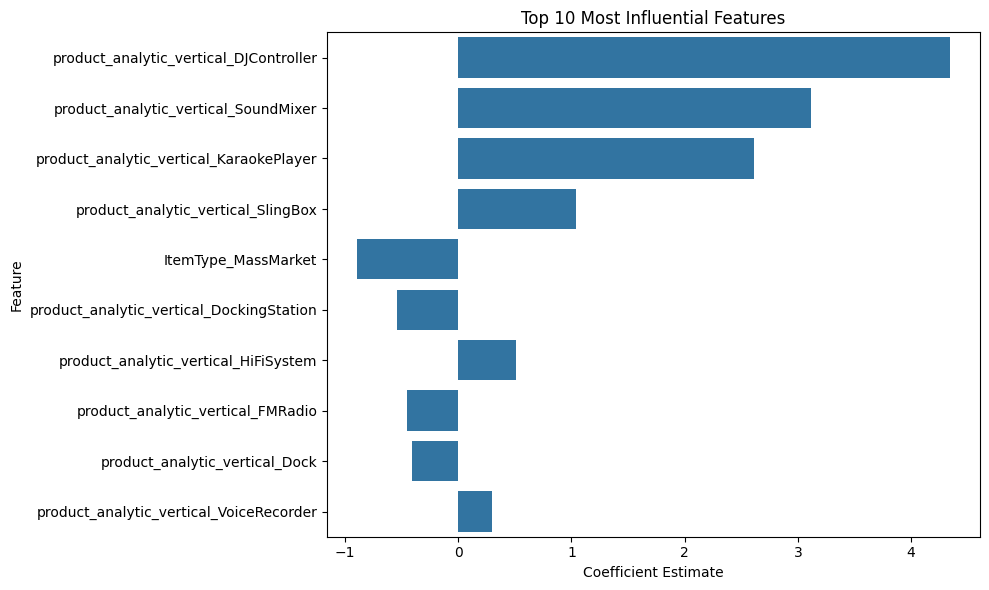

In [ ]:
#Home Audio
linReg(name1,df1)

Dataset: CameraAccessory_final

R² Score: 0.5726
RMSE: 0.66


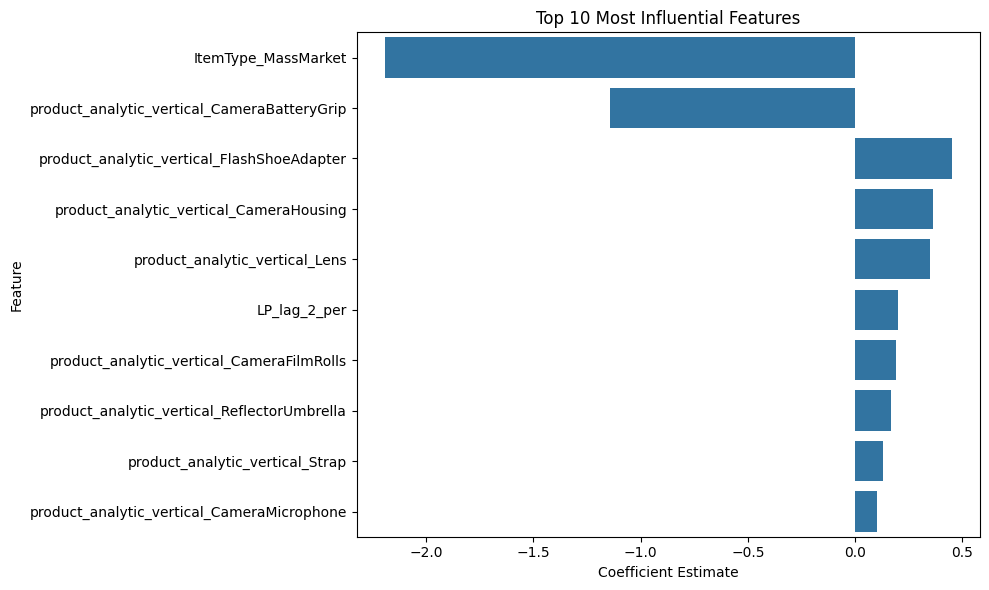

In [ ]:
#CameraAccessory
linReg(name2,df2)

Dataset: GamingAccessory_final

R² Score: 0.6400
RMSE: 0.58


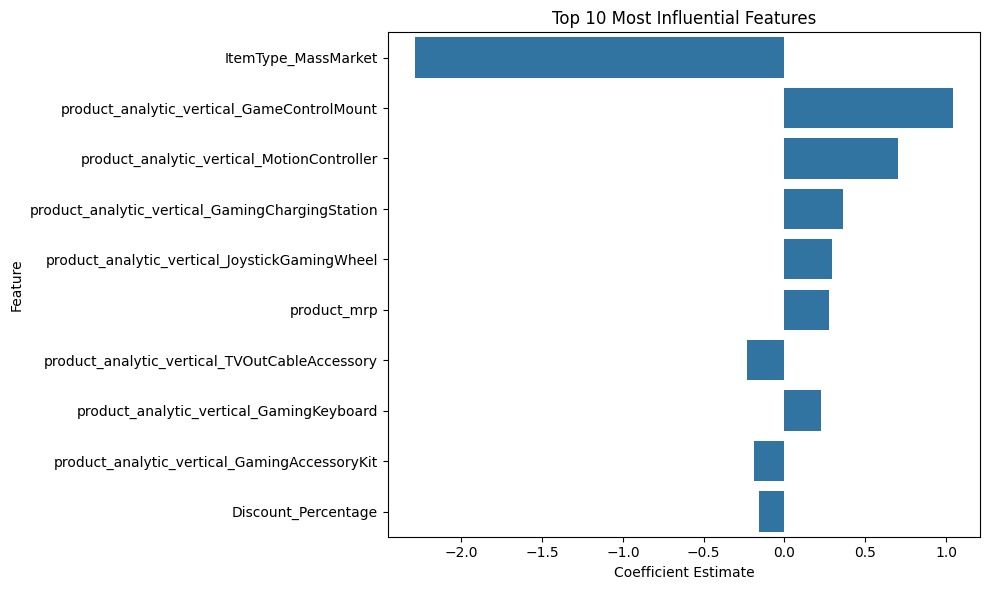

In [ ]:
#GamingAccessory
linReg(name3,df3)

In [ ]:
def olsMod(name,df):
  # Split features and target
  X = df.drop(columns='gmv')
  y = df['gmv']
  # Add constant for intercept
  X_df = sm.add_constant(X)
  # Build and fit OLS model using the aligned y
  ols_model = sm.OLS(y, X_df)
  ols_results = ols_model.fit()
  # View summary
  print(f"Dataset: {name}",end='\n\n')
  print(ols_results.summary())
  predictions = ols_results.predict(X_df)
  # You can optionally display or inspect the predictions
  print("Sample predictions:", predictions.head())
  rmse = math.sqrt(np.mean(np.square(predictions - y)))
  print("RMSE:", rmse)

In [ ]:
#Home Audio
olsMod(name1,df1)

Dataset: HomeAudio_final

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     2424.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        12:48:48   Log-Likelihood:            -1.0589e+05
No. Observations:               96056   AIC:                         2.118e+05
Df Residuals:                   96020   BIC:                         2.122e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [ ]:
#CameraAccessory
olsMod(name2,df2)

Dataset: CameraAccessory_final

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     5344.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        12:49:01   Log-Likelihood:            -1.9394e+05
No. Observations:              193411   AIC:                         3.880e+05
Df Residuals:                  193363   BIC:                         3.885e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [ ]:
#GamingAccessory
olsMod(name3,df3)

Dataset: GamingAccessory_final

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     7969.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        12:49:02   Log-Likelihood:            -1.4909e+05
No. Observations:              168068   AIC:                         2.983e+05
Df Residuals:                  168027   BIC:                         2.987e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

RFE

In [ ]:
def rfe(name,df):
  # Split features and target
  X = df.drop(columns='gmv')
  y = df['gmv']
  # Split the data before preprocessing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Base model for RFE
  lm = LinearRegression()
  rfe = RFE(estimator=lm, n_features_to_select=10)
  rfe = rfe.fit(X_train, y_train)

  # To get the selected feature names after RFE on processed data,
  feature_names_processed = X.columns

  # Use the support_ attribute from the fitted RFE to select feature names
  selected_features_processed = feature_names_processed[rfe.support_]

  print("Selected Features (after preprocessing):", selected_features_processed.tolist())
  # Filter the PROCESSED training data with selected features
  x_train_rfe = X_train.values[:, rfe.support_]
  x_test_rfe = X_test.values[:, rfe.support_]
  x_rfe = x_train_rfe

  # Add constant for intercept
  x_rfe_const = sm.add_constant(x_rfe)
  # Fit OLS model
  # y_train should align with x_train_rfe. Since the split was done before preprocessing and no rows were dropped during preprocessing, y_train is aligned.
  model_rfe = sm.OLS(y_train, x_rfe_const)
  results_rfe = model_rfe.fit()
  # Display coefficients and statistics
  print(results_rfe.summary())


In [ ]:
#Home Audio
rfe(name1,df1)

Selected Features (after preprocessing): ['product_analytic_vertical_DJController', 'product_analytic_vertical_Dock', 'product_analytic_vertical_DockingStation', 'product_analytic_vertical_FMRadio', 'product_analytic_vertical_HiFiSystem', 'product_analytic_vertical_KaraokePlayer', 'product_analytic_vertical_SlingBox', 'product_analytic_vertical_SoundMixer', 'product_analytic_vertical_VoiceRecorder', 'ItemType_MassMarket']
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     4562.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        12:49:04   Log-Likelihood:                -91342.
No. Observations:               76844   AIC:                         1.827e+05
Df Residuals:        

In [ ]:
#CameraAccessory
rfe(name2,df2)

Selected Features (after preprocessing): ['LP_lag_2_per', 'product_analytic_vertical_CameraBattery', 'product_analytic_vertical_CameraBatteryCharger', 'product_analytic_vertical_CameraBatteryGrip', 'product_analytic_vertical_CameraFilmRolls', 'product_analytic_vertical_CameraHousing', 'product_analytic_vertical_Lens', 'product_analytic_vertical_ReflectorUmbrella', 'product_analytic_vertical_Strap', 'ItemType_MassMarket']
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                 1.911e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        12:49:18   Log-Likelihood:            -1.5697e+05
No. Observations:              154728   AIC:                         3.140e+05
Df Residuals:         

In [ ]:
#GamingAccessory
rfe(name3,df3)

Selected Features (after preprocessing): ['product_mrp', 'Discount_Percentage', 'LP_lag_2_per', 'product_analytic_vertical_GameControlMount', 'product_analytic_vertical_GamingChargingStation', 'product_analytic_vertical_GamingKeyboard', 'product_analytic_vertical_JoystickGamingWheel', 'product_analytic_vertical_MotionController', 'product_analytic_vertical_TVOutCableAccessory', 'ItemType_MassMarket']
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                 2.206e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        12:49:23   Log-Likelihood:            -1.2678e+05
No. Observations:              134454   AIC:                         2.536e+05
Df Residuals:                  134443   BIC

**GB** for features selection

In [ ]:
l1=[]

def greedy_elim(df):
    # Split features and target
    X = df.drop(columns='gmv')  # 'gmv' is your target
    y = df['gmv']
    # Initialize model
    model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, random_state=42)
    # RFE setup - you can change n_features_to_select
    feat_selector = RFE(estimator=model, step=1, n_features_to_select=6)
    # Fit RFE
    feat_selector.fit(X, y)
    # Extract selected features
    selected_features = X.columns[feat_selector.support_].tolist()
    print("Selected Features:", selected_features)
    l1.append(selected_features)

for name,df in data_final:
  print(f'{name} dataset : ',end='\n\n')
  greedy_elim(df)


HomeAudio_final dataset : 

Selected Features: ['Discount_Percentage', 'inc_LP_MA1', 'LP_lag_2_per', 'product_analytic_vertical_DJController', 'product_analytic_vertical_HomeAudioSpeaker', 'ItemType_MassMarket']
CameraAccessory_final dataset : 

Selected Features: ['Discount_Percentage', 'inc_LP_MA1', 'LP_lag_1_per', 'LP_lag_2_per', 'product_analytic_vertical_Lens', 'ItemType_MassMarket']
GamingAccessory_final dataset : 

Selected Features: ['units', 'product_mrp', 'Discount_Percentage', 'product_analytic_vertical_MotionController', 'product_analytic_vertical_TVOutCableAccessory', 'ItemType_MassMarket']


In [ ]:
l2=[]

def greedy_elim(df):
    target_col = 'gmv'
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")
    X = df.drop(columns=target_col)
    y = df[target_col]
    # Use a lighter model
    model = GradientBoostingRegressor(n_estimators=20, learning_rate=0.1, max_depth=3, random_state=42)

    # Use a higher step for faster RFE
    selector = RFE(estimator=model, step=5, n_features_to_select=10)
    selector.fit(X, y)

    feature_names = X.columns
    selected_features = feature_names[selector.support_].tolist()

    print("Selected Features:", selected_features)
    l2.append(selected_features)

for name,df in data_final:
  print(f'{name} dataset : ',end='\n\n')
  greedy_elim(df)



HomeAudio_final dataset : 

Selected Features: ['units', 'sla', 'Discount_Percentage', 'Total Investment', 'inc_LP_MA1', 'LP_lag_2_per', 's1_fact_order_payment_type_Prepaid', 'product_analytic_vertical_DJController', 'product_analytic_vertical_HomeAudioSpeaker', 'ItemType_MassMarket']
CameraAccessory_final dataset : 

Selected Features: ['units', 'product_procurement_sla', 'Discount_Percentage', 'inc_LP_MA1', 'LP_lag_1_per', 'LP_lag_2_per', 'product_analytic_vertical_CameraBag', 'product_analytic_vertical_CameraBattery', 'product_analytic_vertical_Lens', 'ItemType_MassMarket']
GamingAccessory_final dataset : 

Selected Features: ['units', 'product_mrp', 'Discount_Percentage', 'product_analytic_vertical_GamingSpeaker', 'product_analytic_vertical_JoystickGamingWheel', 'product_analytic_vertical_MotionController', 'product_analytic_vertical_TVOutCableAccessory', 'delivery_status_Early', 'delivery_status_On time', 'ItemType_MassMarket']


**Koyak Model**

In [ ]:
def kyk(select_feat,df,name):
    print(f'{name} dataset :',end='\n')
    # Assuming df_homeAudio is already loaded and pre-cleaned from previous cells (NaNs, infs handled
    # Create lag variable (Koyck) - Assuming df_homeAudio is already loaded and pre-cleaned from previous cells (NaNs, infs handled).
    df['gmv_lag1'] = df['gmv'].shift(1)
    df = df.fillna(0) # Be cautious with fillna(0), especially before scaling
    X = df.drop(columns='gmv')
    y = df['gmv']
    # Train/test split on original X and y
    x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

    # Define selected features
    selected_processed_features = select_feat

    # Subset based on selected features
    x_train1 = x_train[selected_processed_features]
    # Add a constant (intercept term) to the feature set

    # FIX: Reset the index of x_train1 BEFORE adding the constant
    # This ensures x_train1_reset has a default integer index (0, 1, 2, ...)
    x_train1_reset = x_train1.reset_index(drop=True)
    x_train1_const = sm.add_constant(x_train1_reset)

    # The fix for y_train was already present and is correct:
    # This ensures y_train_aligned has a default integer index (0, 1, 2, ...)
    y_train_aligned = y_train.reset_index(drop=True)

    # Now fit the OLS model using the aligned y_train and index-reset x_train1_const
    # Both y_train_aligned and x_train1_const now have matching default integer indices.
    model = sm.OLS(y_train_aligned, x_train1_const)
    results = model.fit()

    # Show coefficients
    print("Coefficients:\n", results.params)

    # Show full statistical summary
    print("\nModel Summary:\n")
    print(results.summary(),end='\n\n')

In [ ]:
#Home Audio
print(f'{name1} model run with estimator=50')
kyk(l1[0],df1,name1)

print(f'{name1} model run with estimator=20')
kyk(l2[0],df1,name1)

HomeAudio_final model run with estimator=50
HomeAudio_final dataset :
Coefficients:
 const                                         0.46
Discount_Percentage                          -0.07
inc_LP_MA1                                    0.09
LP_lag_2_per                                  0.23
product_analytic_vertical_DJController        4.58
product_analytic_vertical_HomeAudioSpeaker    0.25
ItemType_MassMarket                          -1.00
dtype: float64

Model Summary:

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     8822.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:20:51   Log-Likelihood:                -82260.
No. Observations:               72042   AIC:        

In [ ]:
#Camera Accessory
print(f'{name2} model run with estimator=50')
kyk(l1[1],df2,name2)

print(f'{name2} model run with estimator=20')
kyk(l2[1],df2,name2)

CameraAccessory_final model run with estimator=50
CameraAccessory_final dataset :
Coefficients:
 const                             1.95
Discount_Percentage              -0.05
inc_LP_MA1                        0.07
LP_lag_1_per                      0.04
LP_lag_2_per                      0.20
product_analytic_vertical_Lens    0.30
ItemType_MassMarket              -2.17
dtype: float64

Model Summary:

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                 2.989e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:20:52   Log-Likelihood:            -1.4751e+05
No. Observations:              145058   AIC:                         2.950e+05
Df Residuals:                  145051   BIC: 

In [ ]:
#Gaming Accessory
print(f'{name3} model run with estimator=50')
kyk(l1[2],df3,name3)

print(f'{name2} model run with estimator=20')
kyk(l2[2],df3,name3)

GamingAccessory_final model run with estimator=50
GamingAccessory_final dataset :
Coefficients:
 const                                            2.34
units                                            0.14
product_mrp                                      0.21
Discount_Percentage                             -0.20
product_analytic_vertical_MotionController       0.84
product_analytic_vertical_TVOutCableAccessory   -0.19
ItemType_MassMarket                             -2.50
dtype: float64

Model Summary:

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                 3.109e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:20:53   Log-Likelihood:            -1.2277e+05
No. Observations:  

OLS Model

In [ ]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    """
    included = list(initial_list)
    while True:
        changed = False

        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pvals[new_column] = model.pvalues[new_column]
        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_feature = new_pvals.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature:30} with p-value {best_pval:.6f}')

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f'Drop {worst_feature:30} with p-value {worst_pval:.6f}')

        if not changed:
            break

    return included


In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def ols_model(df,name):
  # Split features and target
  # Create lag variable (Koyck)
  print(f'{name} dataset :',end='\n')
  df['gmv_lag1'] = df['gmv'].shift(1)
  df = df.fillna(0)

  # Separate features and target
  X = df.drop(columns='gmv')
  y = df['gmv']
  # Train/test split
  x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)
  # Ready for stepwise_selection or modeling
  print("Shape of x_train after preprocessing:", x_train.shape)

  # Get feature names
  feature_names = X.columns.tolist()
  # Create DataFrame with correct index
  X_train_df = pd.DataFrame(x_train, columns=feature_names, index=y_train.index)
  # Run stepwise selection
  selected_features = stepwise_selection(X_train_df, y_train)

  print("Selected Features:", selected_features)
  # Build DataFrames for both train and test using correct indices
  X_test_df = pd.DataFrame(x_cv, columns=feature_names, index=y_cv.index)

  # Subset based on selected features
  X_train_final = X_train_df[selected_features]
  X_test_final = X_test_df[selected_features]

  # 3. Add constant (intercept) to both sets
  X_train_const = sm.add_constant(X_train_final)
  X_test_const = sm.add_constant(X_test_final)

  # 4. Fit OLS model on training data
  ols_model = sm.OLS(y_train, X_train_const).fit()

  # 5. Predict on test data
  y_pred = ols_model.predict(X_test_const)

  # 6. Evaluate performance
  r2 = r2_score(y_cv, y_pred)
  rmse = np.sqrt(mean_squared_error(y_cv, y_pred))

  # 7. Output results
  print(f"Test Set R² Score: {r2:.4f}")
  print(f"Test Set RMSE: {rmse:.4f}")

  # 8. (Optional) Show OLS summary
  print("\nOLS Model Summary:")
  print(ols_model.summary())
  # Plot predicted vs. actual
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=y_cv, y=y_pred)
  plt.plot([y_cv.min(), y_cv.max()], [y_cv.min(), y_cv.max()], '--r', linewidth=2)
  plt.xlabel("Actual GMV")
  plt.ylabel("Predicted GMV")
  plt.title("Actual vs. Predicted GMV (Test Set)")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  residuals = y_cv - y_pred

  plt.figure(figsize=(8, 6))
  sns.histplot(residuals, kde=True, bins=30, color='skyblue')
  plt.axvline(0, color='red', linestyle='--')
  plt.xlabel("Residuals")
  plt.title("Distribution of Residuals")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # Get p-values and drop insignificant features
  pvals = ols_model.pvalues.drop('const')  # Exclude intercept
  insignificant_features = pvals[pvals > 0.05].index.tolist()

  print("Dropping insignificant features:", insignificant_features)

  # Rebuild X without them
  X_train_refined = X_train_final.drop(columns=insignificant_features)
  X_test_refined = X_test_final.drop(columns=insignificant_features)

  # Refit model
  X_train_refined_const = sm.add_constant(X_train_refined)
  X_test_refined_const = sm.add_constant(X_test_refined)

  refined_model = sm.OLS(y_train, X_train_refined_const).fit()
  y_pred_refined = refined_model.predict(X_test_refined_const)

  # Evaluate
  r2 = r2_score(y_cv, y_pred_refined)
  rmse = np.sqrt(mean_squared_error(y_cv, y_pred_refined))

  print(f"\nRefined Model R²: {r2:.4f}")
  print(f"Refined Model RMSE: {rmse:.2f}")
  print(refined_model.summary())
  from statsmodels.stats.outliers_influence import variance_inflation_factor

  # VIF requires DataFrame (no constant)
  vif_df = pd.DataFrame()
  vif_df["Feature"] = X_train_refined.columns
  vif_df["VIF"] = [variance_inflation_factor(X_train_refined.values, i)
                  for i in range(X_train_refined.shape[1])]

  print("\nVariance Inflation Factors:")
  print(vif_df.sort_values(by="VIF", ascending=False))
  # Define high VIF threshold
  high_vif_threshold = 10

  # Identify features to drop
  high_vif_features = vif_df[vif_df["VIF"] > high_vif_threshold]["Feature"].tolist()

  print("Features to drop due to high VIF:", high_vif_features)

  # Drop from training and test sets
  X_train_clean = X_train_refined.drop(columns=high_vif_features)
  X_test_clean = X_test_refined.drop(columns=high_vif_features)

  # Add constant
  X_train_clean_const = sm.add_constant(X_train_clean)
  X_test_clean_const = sm.add_constant(X_test_clean)

  # Refit the model
  clean_model = sm.OLS(y_train, X_train_clean_const).fit()

  # Predict and evaluate
  y_pred_clean = clean_model.predict(X_test_clean_const)
  r2 = r2_score(y_cv, y_pred_clean)
  rmse = np.sqrt(mean_squared_error(y_cv, y_pred_clean))

  print(f"\nAfter Dropping High-VIF Features:")
  print(f"R² Score: {r2:.4f}")
  print(f"RMSE: {rmse:.2f}")
  print(clean_model.summary())


HomeAudio_final dataset :
Shape of x_train after preprocessing: (72042, 37)
Add  product_analytic_vertical_HomeAudioSpeaker with p-value 0.000000
Add  product_analytic_vertical_VoiceRecorder with p-value 0.000000
Add  LP_lag_2_per                   with p-value 0.000000
Add  gmv_lag1                       with p-value 0.000000
Add  units                          with p-value 0.000000
Add  inc_PO_MA1                     with p-value 0.000000
Add  inc_LP_MA1                     with p-value 0.000000
Add  ItemType_MassMarket            with p-value 0.000000
Add  product_analytic_vertical_DJController with p-value 0.000000
Add  product_analytic_vertical_FMRadio with p-value 0.000000
Drop product_analytic_vertical_VoiceRecorder with p-value 0.541233
Add  LP_lag_1_per                   with p-value 0.000000
Add  product_analytic_vertical_SoundMixer with p-value 0.000000
Add  product_analytic_vertical_HiFiSystem with p-value 0.000000
Add  s1_fact_order_payment_type_Prepaid with p-value 0.0000

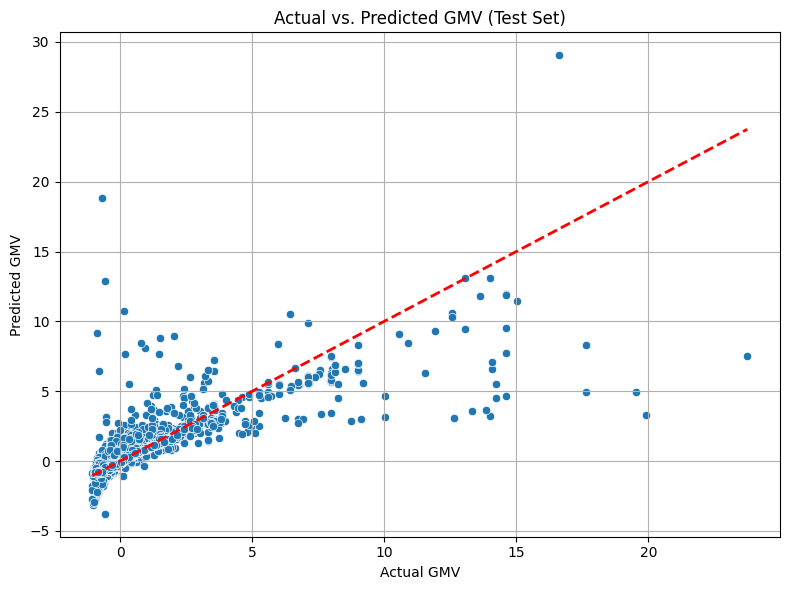

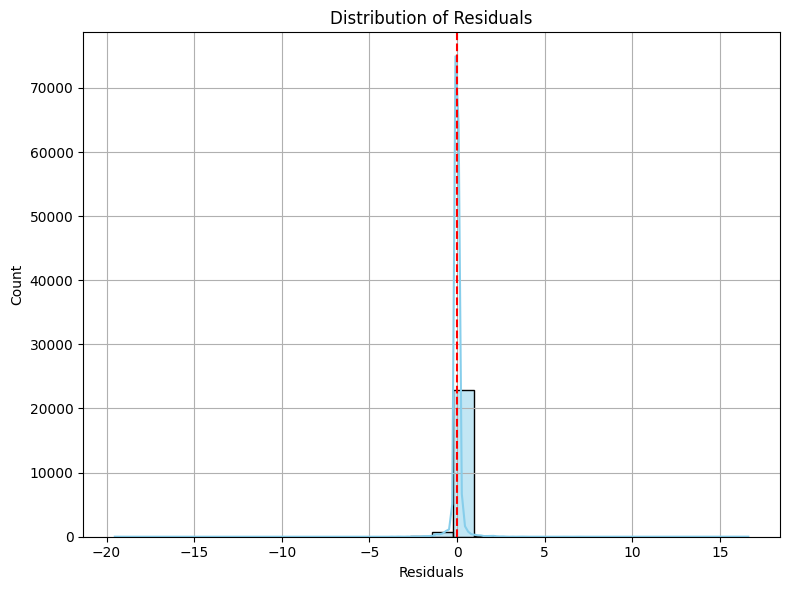

Dropping insignificant features: []

Refined Model R²: 0.7876
Refined Model RMSE: 0.46
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                 1.388e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:21:38   Log-Likelihood:                -43783.
No. Observations:               72042   AIC:                         8.761e+04
Df Residuals:                   72020   BIC:                         8.781e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [ ]:
#Home Audio
ols_model(df1,name1)

CameraAccessory_final dataset :
Shape of x_train after preprocessing: (145058, 49)
Add  product_analytic_vertical_Flash with p-value 0.000000
Add  product_analytic_vertical_CameraTripod with p-value 0.000000
Add  LP_lag_2_per                   with p-value 0.000000
Add  product_analytic_vertical_CameraBattery with p-value 0.000000
Add  gmv_lag1                       with p-value 0.000000
Add  inc_PO_MA1                     with p-value 0.000000
Add  inc_LP_MA1                     with p-value 0.000000
Add  product_analytic_vertical_Lens with p-value 0.000000
Add  ItemType_MassMarket            with p-value 0.000000
Drop product_analytic_vertical_CameraTripod with p-value 0.496478
Add  units                          with p-value 0.000000
Drop product_analytic_vertical_Flash with p-value 0.364477
Add  LP_lag_1_per                   with p-value 0.000000
Add  product_analytic_vertical_CameraBatteryGrip with p-value 0.000000
Add  product_procurement_sla        with p-value 0.000000
Add  sl

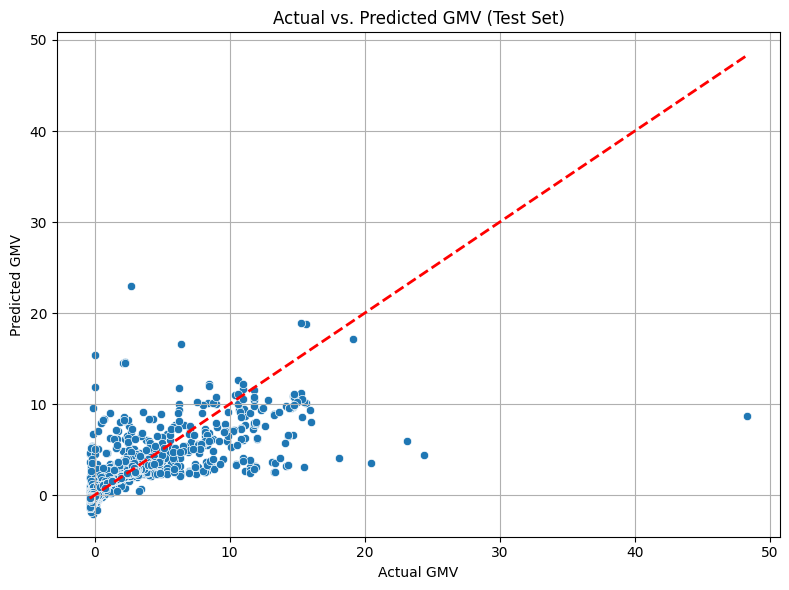

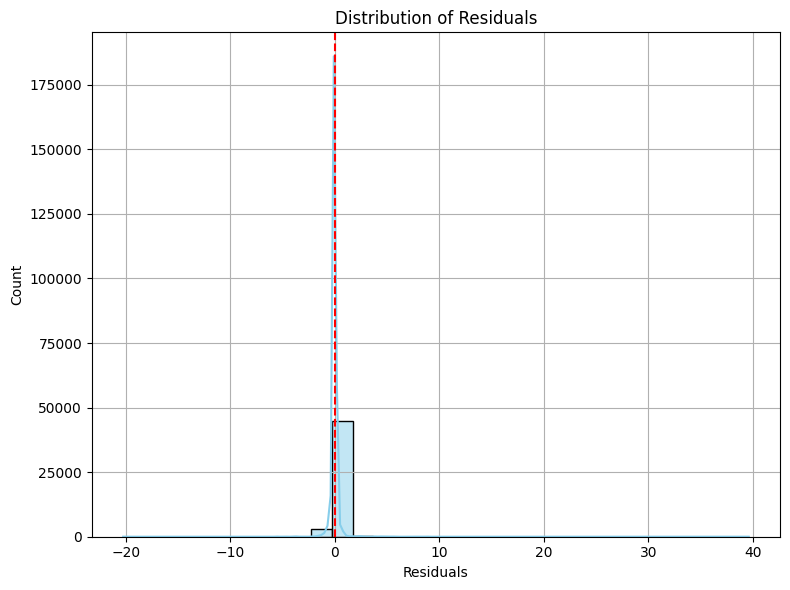

Dropping insignificant features: []

Refined Model R²: 0.7310
Refined Model RMSE: 0.52
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 2.067e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:23:43   Log-Likelihood:            -1.1083e+05
No. Observations:              145058   AIC:                         2.217e+05
Df Residuals:                  145038   BIC:                         2.219e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
--------

In [ ]:
#Camera Accessory
ols_model(df2,name2)

GamingAccessory_final dataset :
Shape of x_train after preprocessing: (126051, 42)
Add  LP_lag_2_per                   with p-value 0.000000
Add  product_analytic_vertical_GamingHeadset with p-value 0.000000
Add  units                          with p-value 0.000000
Add  product_analytic_vertical_GamingMouse with p-value 0.000000
Add  product_analytic_vertical_TVOutCableAccessory with p-value 0.000000
Add  gmv_lag1                       with p-value 0.000000
Add  inc_PO_MA1                     with p-value 0.000000
Add  inc_LP_MA1                     with p-value 0.000000
Add  ItemType_MassMarket            with p-value 0.000000
Add  product_mrp                    with p-value 0.000000
Add  Discount_Percentage            with p-value 0.000000
Add  product_procurement_sla        with p-value 0.000000
Add  LP_lag_1_per                   with p-value 0.000000
Add  product_analytic_vertical_GamingKeyboard with p-value 0.000000
Add  product_analytic_vertical_JoystickGamingWheel with p-value 

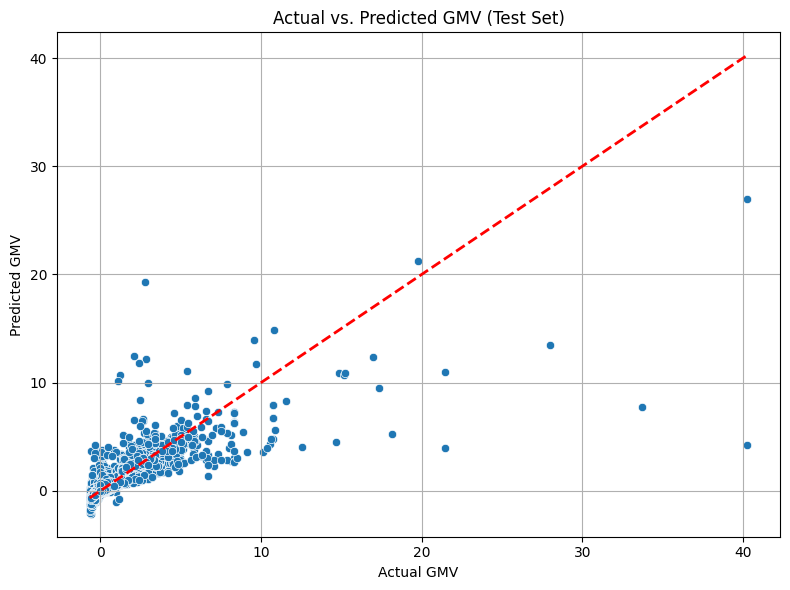

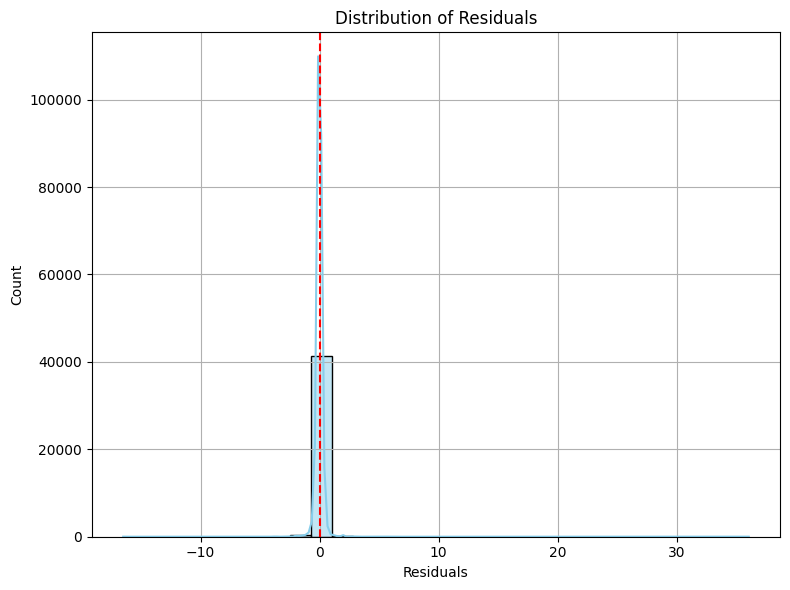

Dropping insignificant features: []

Refined Model R²: 0.7957
Refined Model RMSE: 0.44
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                 1.961e+04
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:26:08   Log-Likelihood:                -74234.
No. Observations:              126051   AIC:                         1.485e+05
Df Residuals:                  126022   BIC:                         1.488e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------

In [ ]:
#Gaming Accessory
ols_model(df3,name3)

**Distributed Log Model**

In [ ]:
# Distributed Log Model

def distr_log_model(name,df):
  print(f'{name} dataset :',end='\n')
  df['gmv_lag1'] = df['gmv'].shift(1)
  df['gmv_lag2'] = df['gmv'].shift(2) # Changed from GMV_2
  df['gmv_lag3'] = df['gmv'].shift(3) # Changed from GMV_3

  # Handle NaNs created by shifting. Fill with 0.
  df = df.fillna(0)

  # Separate features (X) and target (y) AFTER adding lag variables
  X = df.drop(columns='gmv')
  y = df['gmv']

  # Train/test split on original X and y
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # Using 0.25 as in previous OLS evaluation

  # Convert processed training data to DataFrame for stepwise selection
  feature_names= X.columns.tolist()
  X_train_df = pd.DataFrame(X_train, columns=feature_names, index=y_train.index)

  # Run stepwise selection on the processed training data
  selected_features = stepwise_selection(X_train_df, y_train)

  print('resulting features:')
  print(selected_features)
  x_train1 = X_train_df.loc[:, selected_features]
  model = sm.OLS(y_train, sm.add_constant(x_train1)) # Add constant here
  results = model.fit()
  print(results.params)
  print(results.summary())

  # Predicting on the test data
  X_test_df = pd.DataFrame(X_test, columns=feature_names, index=y_test.index)
  x_cv2 = X_test_df.loc[:, selected_features]
  x_cv2_const = sm.add_constant(x_cv2)
  y_pred_cv = results.predict(x_cv2_const)
  r2_cv = r2_score(y_test, y_pred_cv)
  rmse_cv = np.sqrt(mean_squared_error(y_test, y_pred_cv))

  print(f"\nTest Set R² Score: {r2_cv:.4f}")
  print(f"Test Set RMSE: {rmse_cv:.4f}")
  rmse=math.sqrt(np.mean(np.square((results.predict(x_cv2_const)-y_test))))
  print(f"Test Set RMSE: {rmse:.4f}")

In [ ]:
#Home Audio
distr_log_model(name1,df1)

HomeAudio_final dataset :
Add  gmv_lag2                       with p-value 0.000000
Add  gmv_lag3                       with p-value 0.000000
Add  LP_lag_2_per                   with p-value 0.000000
Add  gmv_lag1                       with p-value 0.000000
Add  units                          with p-value 0.000000
Add  inc_PO_MA1                     with p-value 0.000000
Add  inc_LP_MA1                     with p-value 0.000000
Add  ItemType_MassMarket            with p-value 0.000000
Add  product_analytic_vertical_DJController with p-value 0.000000
Add  product_analytic_vertical_FMRadio with p-value 0.000000
Add  LP_lag_1_per                   with p-value 0.000000
Add  product_analytic_vertical_SoundMixer with p-value 0.000000
Add  product_analytic_vertical_HiFiSystem with p-value 0.000000
Add  s1_fact_order_payment_type_Prepaid with p-value 0.000000
Add  deliverybdays                  with p-value 0.000000
Add  product_analytic_vertical_DockingStation with p-value 0.000000
Add  Disc

In [ ]:
#Camera Accessory
distr_log_model(name2,df2)

CameraAccessory_final dataset :
Add  gmv_lag2                       with p-value 0.000000
Add  gmv_lag3                       with p-value 0.000000
Add  LP_lag_2_per                   with p-value 0.000000
Add  gmv_lag1                       with p-value 0.000000
Add  inc_PO_MA1                     with p-value 0.000000
Add  inc_LP_MA1                     with p-value 0.000000
Add  product_analytic_vertical_Lens with p-value 0.000000
Add  ItemType_MassMarket            with p-value 0.000000
Add  units                          with p-value 0.000000
Add  LP_lag_1_per                   with p-value 0.000000
Add  product_analytic_vertical_CameraBatteryGrip with p-value 0.000000
Add  product_procurement_sla        with p-value 0.000000
Add  sla                            with p-value 0.000000
Add  s1_fact_order_payment_type_Prepaid with p-value 0.000000
Add  deliverybdays                  with p-value 0.000000
Add  product_analytic_vertical_CameraBatteryCharger with p-value 0.000014
Add  pr

In [ ]:
#Gaming Accessory
distr_log_model(name3,df3)

GamingAccessory_final dataset :
Add  gmv_lag2                       with p-value 0.000000
Add  gmv_lag3                       with p-value 0.000000
Add  LP_lag_2_per                   with p-value 0.000000
Add  units                          with p-value 0.000000
Add  gmv_lag1                       with p-value 0.000000
Add  inc_PO_MA1                     with p-value 0.000000
Add  inc_LP_MA1                     with p-value 0.000000
Add  ItemType_MassMarket            with p-value 0.000000
Add  product_mrp                    with p-value 0.000000
Add  Discount_Percentage            with p-value 0.000000
Add  product_procurement_sla        with p-value 0.000000
Add  LP_lag_1_per                   with p-value 0.000000
Add  product_analytic_vertical_JoystickGamingWheel with p-value 0.000000
Add  product_analytic_vertical_GamingKeyboard with p-value 0.000000
Add  product_analytic_vertical_MotionController with p-value 0.000000
Add  PO_lag_1_per-2                 with p-value 0.000000
Add

**Exponential/Multiplicative Models**

In [ ]:
name1,df1=data_mod[0] # Home Audio
name2,df2=data_mod[1] # Camera Accessory
name3,df3=data_mod[2] # Gaming Accessory

In [ ]:
def exp_mul_model(name, df):
    print(f'{name} dataset :')

    df_transformed = df.copy()
    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns.tolist()

    # Log1p transform numeric columns if no negatives
    for col in numeric_cols:
        if (df_transformed[col] >= 0).all():
            df_transformed[col] = np.log1p(df_transformed[col])
        else:
            print(f"Warning: Column '{col}' contains negative values. Log transformation skipped.")

    df_transformed = df_transformed.fillna(0).replace([np.inf, -np.inf], 0)

    target_col = 'gmv'
    X = df_transformed.drop(columns=[target_col])
    y = df_transformed[target_col]

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_pipeline = Pipeline([('scaler', StandardScaler())])
    categorical_pipeline = Pipeline([('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ], remainder='drop')

    x_train_raw, x_cv_raw, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

    x_train_processed = preprocessor.fit_transform(x_train_raw)
    x_cv_processed = preprocessor.transform(x_cv_raw)

    feature_names = preprocessor.get_feature_names_out()
    X_train_df = pd.DataFrame(x_train_processed, columns=feature_names, index=y_train.index)
    X_cv_df = pd.DataFrame(x_cv_processed, columns=feature_names, index=y_cv.index)
    result = stepwise_selection(X_train_df, y_train)
    print(f"Selected features ({len(result)}): {result}")
    x_train_selected = X_train_df[result]
    x_cv_selected = X_cv_df[result]

    x_train_selected_const = sm.add_constant(x_train_selected, has_constant='add')
    x_cv_selected_const = sm.add_constant(x_cv_selected, has_constant='add')

    print(f"x_train_selected_const shape: {x_train_selected_const.shape}")
    print(f"x_cv_selected_const shape: {x_cv_selected_const.shape}")

    # Fit model
    model = sm.OLS(y_train, x_train_selected_const)
    results = model.fit()

    print(results.params)
    print(results.summary())

    # Predict on test set
    y_pred_cv = results.predict(x_cv_selected_const)

    # Evaluate test performance
    r2_cv = r2_score(y_cv, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_cv, y_pred_cv))

    print(f"\nTest Set R² Score: {r2_cv:.4f}")
    print(f"Test Set RMSE: {rmse_cv:.4f}")


In [ ]:
#Home Audio
exp_mul_model(name1,df1)

HomeAudio_reduced dataset :
Add  num__delivery_on_time          with p-value 0.000000
Add  cat__product_analytic_vertical_FMRadio with p-value 0.000000
Add  num__LP_lag_2_per              with p-value 0.000000
Add  cat__product_analytic_vertical_Dock with p-value 0.000000
Add  num__inc_LP_MA1                with p-value 0.000000
Add  cat__ItemType_MassMarket       with p-value 0.000000
Add  num__Discount_Percentage       with p-value 0.000000
Add  num__sla                       with p-value 0.000000
Add  num__units                     with p-value 0.000000
Add  cat__product_analytic_vertical_DockingStation with p-value 0.000000
Add  cat__product_analytic_vertical_DJController with p-value 0.000000
Add  cat__product_analytic_vertical_HiFiSystem with p-value 0.000000
Add  cat__product_analytic_vertical_SoundMixer with p-value 0.000000
Add  num__is_holiday                with p-value 0.000000
Add  cat__s1_fact_order_payment_type_Prepaid with p-value 0.000000
Add  num__deliverybdays       

In [ ]:
# Camera Accesory
exp_mul_model(name2,df2)

CameraAccessory_reduced dataset :
Add  num__LP_lag_2_per              with p-value 0.000000
Add  cat__product_analytic_vertical_CameraBag with p-value 0.000000
Add  cat__product_analytic_vertical_Flash with p-value 0.000000
Add  cat__product_analytic_vertical_CameraTripod with p-value 0.000000
Add  cat__product_analytic_vertical_Filter with p-value 0.000000
Add  cat__s1_fact_order_payment_type_Prepaid with p-value 0.000000
Add  num__inc_LP_MA1                with p-value 0.000000
Add  cat__ItemType_MassMarket       with p-value 0.000000
Add  cat__product_analytic_vertical_CameraFilmRolls with p-value 0.000000
Add  cat__product_analytic_vertical_Lens with p-value 0.000000
Add  num__product_procurement_sla   with p-value 0.000000
Add  num__Discount_Percentage       with p-value 0.000000
Drop cat__product_analytic_vertical_CameraBag with p-value 0.282779
Add  num__units                     with p-value 0.000000
Add  cat__product_analytic_vertical_Telescope with p-value 0.000000
Add  num__

In [ ]:
# Gaming Accesory
exp_mul_model(name3,df3)

GamingAccessory_reduced dataset :
Add  num__LP_lag_2_per              with p-value 0.000000
Add  cat__product_analytic_vertical_GamingKeyboard with p-value 0.000000
Add  num__product_mrp               with p-value 0.000000
Add  cat__product_analytic_vertical_GamingMouse with p-value 0.000000
Add  cat__ItemType_MassMarket       with p-value 0.000000
Add  num__product_procurement_sla   with p-value 0.000000
Add  num__Discount_Percentage       with p-value 0.000000
Add  num__inc_PO_MA1                with p-value 0.000000
Add  cat__product_analytic_vertical_GamePad with p-value 0.000000
Add  cat__product_analytic_vertical_GamingMemoryCard with p-value 0.000000
Add  cat__product_analytic_vertical_GamingAccessoryKit with p-value 0.000000
Add  num__units                     with p-value 0.000000
Add  cat__product_analytic_vertical_GamingMousePad with p-value 0.000000
Add  cat__product_analytic_vertical_TVOutCableAccessory with p-value 0.000000
Add  cat__product_analytic_vertical_JoystickGami

**Models Comparison**

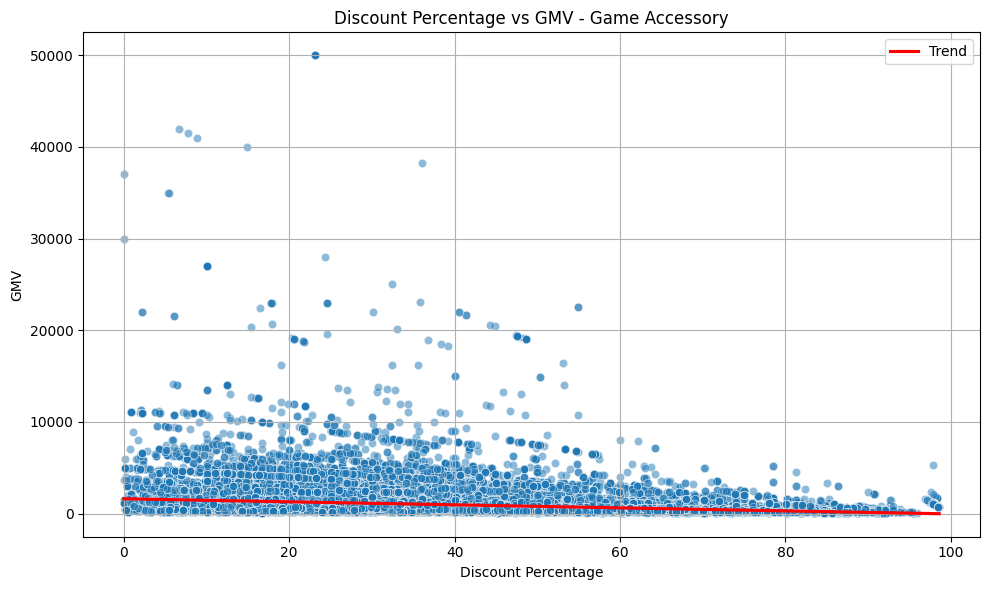

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

# Load dataset

df = pd.read_csv("GamingAccessory.csv")

# Filter valid rows

df_filtered = df[(df['Discount_Percentage'] > 0) & (df['gmv'] > 0)]

# Plot

plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_filtered, x='Discount_Percentage', y='gmv', alpha=0.5)

sns.regplot(data=df_filtered, x='Discount_Percentage', y='gmv', scatter=False, color='red', label='Trend')

plt.title('Discount Percentage vs GMV - Game Accessory')

plt.xlabel('Discount Percentage')

plt.ylabel('GMV')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()



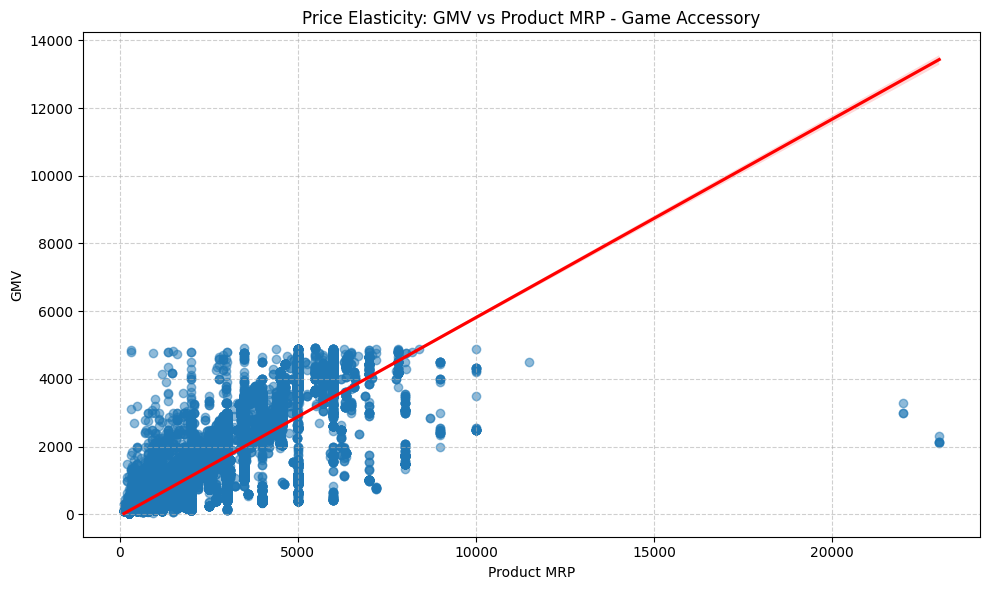

In [ ]:
# Drop rows with missing or zero values for GMV or MRP
df_filtered = df[(df['gmv'] > 0) & (df['product_mrp'] > 0)].copy()

# Optional: remove extreme outliers (you can adjust thresholds)
df_filtered = df_filtered[df_filtered['product_mrp'] < df_filtered['product_mrp'].quantile(0.99)]
df_filtered = df_filtered[df_filtered['gmv'] < df_filtered['gmv'].quantile(0.99)]

# Plotting: GMV vs Product MRP
plt.figure(figsize=(10, 6))
sns.regplot(x='product_mrp', y='gmv', data=df_filtered, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Price Elasticity: GMV vs Product MRP - Game Accessory')
plt.xlabel('Product MRP')
plt.ylabel('GMV')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



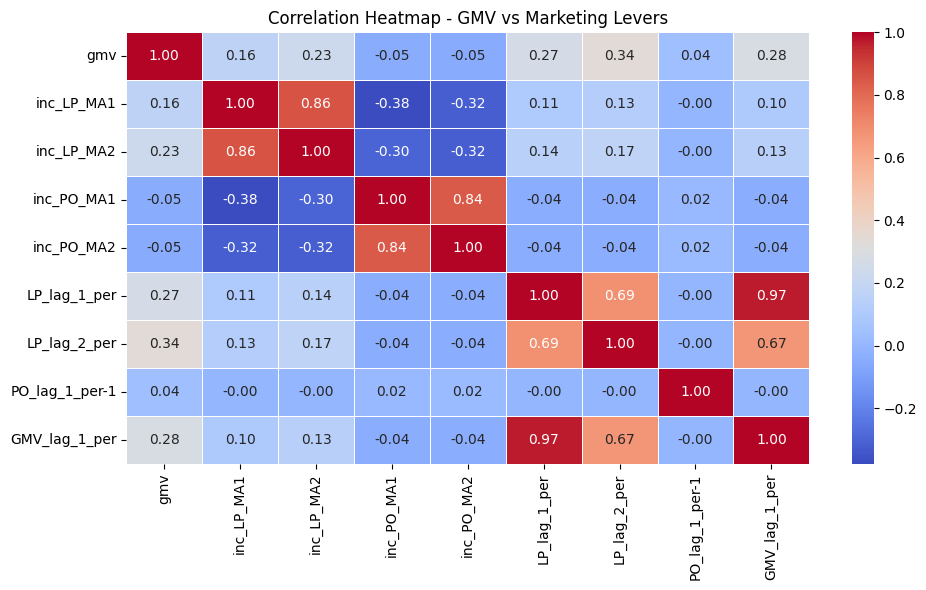

In [ ]:
# Select relevant marketing + GMV columns
marketing_cols = ['gmv', 'inc_LP_MA1', 'inc_LP_MA2', 'inc_PO_MA1', 'inc_PO_MA2',
                  'LP_lag_1_per', 'LP_lag_2_per', 'PO_lag_1_per-1', 'GMV_lag_1_per']

df_marketing = df[marketing_cols].dropna()

# Compute correlation matrix
corr_matrix = df_marketing.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap - GMV vs Marketing Levers')
plt.tight_layout()
plt.show()

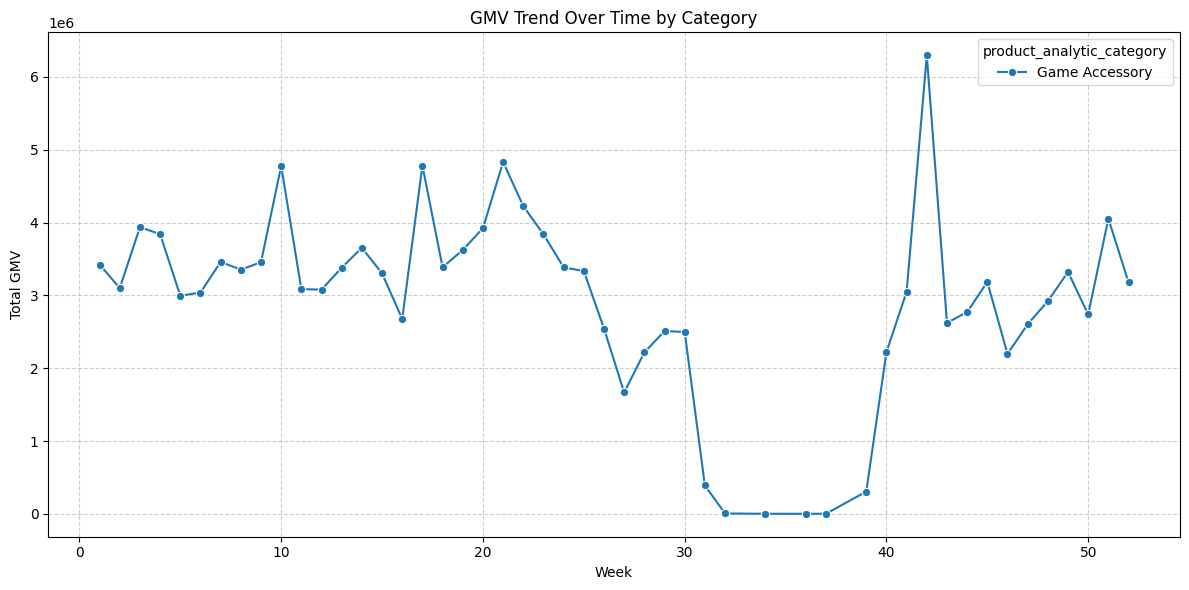

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

# Load your combined dataset with 'week', 'gmv', and 'product_analytic_category' columns

# Example:

# df = pd.read_csv("Combined_Categories.csv")

# For this example, assume you already have Home Audio data:

df = pd.read_csv("GamingAccessory.csv")

df['product_analytic_category'] = 'Game Accessory'  # Tag it for identification

# If you have Gaming and Camera too, load and append them similarly

# df_gaming = pd.read_csv("Gaming.csv")

# df_gaming['product_analytic_category'] = 'Gaming'

# df_camera = pd.read_csv("Camera.csv")

# df_camera['product_analytic_category'] = 'Camera'

# df = pd.concat([df, df_gaming, df_camera])

# Group weekly GMV per category

gmv_trend = df.groupby(['week', 'product_analytic_category'])['gmv'].sum().reset_index()

# Plotting

plt.figure(figsize=(12, 6))

sns.lineplot(data=gmv_trend, x='week', y='gmv', hue='product_analytic_category', marker='o')

plt.title('GMV Trend Over Time by Category')

plt.xlabel('Week')

plt.ylabel('Total GMV')

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

